In [8]:
import pandas as pd
import os
import re

os.chdir('/home/adri/Projects/phd/pipeline')

In [24]:
# Read signling data
path = 'data/raw/signaling_data.csv'
signaling_df = pd.read_csv(path)

# Remove mutations that are not alanin scan
alanin_scan_mask = signaling_df.Mutant.apply(lambda x: bool(re.match('([A-Z])(\d+)$', str(x))))
signaling_df = signaling_df.loc[alanin_scan_mask]

# Remove non usefull columns
cols_of_interst = ['Position','Emax_avg_corr_Gi2_HU210', 'Emax_avg_corr_bArr1_HU210']
signaling_df = signaling_df[cols_of_interst]

# Change column names
signaling_df.columns = ['position', 'gi_emax', 'barr_emax']

# Set mutant number as index
# signaling_df = signaling_df.set_index('position')

# Set boolean masks for biased and wt
biased_mask = (signaling_df.barr_emax == 0) & (signaling_df.gi_emax > 0)
wt_mask = (signaling_df.barr_emax > 0) & (signaling_df.gi_emax > 0)
    
# Create a field wih categorical signal information
signaling_df['profile'] = 2
signaling_df.loc[wt_mask, 'profile'] = 0
signaling_df.loc[biased_mask, 'profile'] = 1

# Keep only the categorical labels
signaling_df = signaling_df[['position', 'profile']]

# Remove mutants with other signaling profiles
signaling_df = signaling_df[signaling_df.profile != 2]

# add the profile of the WT
signaling_df = pd.concat([signaling_df, pd.DataFrame({'position': ['WT'], 'profile': [0]})])

# save data without index
signaling_df.to_csv('data/processed/signaling_data.csv', index=False)

In [25]:
signaling_df

,position,profile
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
368,357,0
369,358,0
370,359,0
371,360,0


In [29]:
signaling_df

,position,profile
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
310,357,0
311,358,0
312,359,0
313,360,0


In [30]:
contact_df

,Unnamed: 0,305-307,131-70,203-206,120-124,110-112,299-76,262-264,297-300,173-185,...,257-295,101-33,109-26,35-98,24-281,184-272,183-272,222-307,222-301,222-304
0,302,0.998,0.475,0.660,0.993,0.998,0.935,0.998,0.845,0.792,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,302,0.993,0.407,0.698,0.998,0.998,0.963,0.998,0.858,0.863,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,302,0.995,0.395,0.675,0.995,0.998,0.968,0.998,0.905,0.940,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,302,0.993,0.512,0.662,0.990,0.998,0.880,0.998,0.860,0.537,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,302,0.995,0.507,0.662,0.995,0.998,0.945,0.998,0.865,0.907,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,159,0.995,0.018,0.647,0.993,0.998,0.907,0.998,0.735,0.950,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
176,159,0.998,0.037,0.640,0.998,0.998,0.790,0.998,0.865,0.935,...,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
177,159,0.998,0.007,0.720,0.993,0.998,0.810,0.998,0.765,0.915,...,0.000,0.003,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000
178,159,0.998,0.050,0.642,0.988,0.998,0.863,0.995,0.713,0.935,...,0.000,0.000,0.000,0.003,0.003,0.000,0.000,0.000,0.000,0.000


In [35]:
# load singaling data
signaling_df = pd.read_csv('data/interim/processed_signaling_data.csv')
# load contact data
contacts_df = pd.read_csv('data/interim/frequencies/frequencies.tsv')
# set name of the first column to position
contacts_df.columns = ['position'] + list(contacts_df.columns[1:])
# merge both dataframes
merged_df = pd.merge(signaling_df, contacts_df, on='position', how='inner')
# save merged dataframe
merged_df.to_csv('data/processed/features.csv', index=False)

In [40]:
import yaml
import itertools
import hashlib
from glob import glob
import os

os.chdir('/home/adri/Projects/phd/pipeline')

In [64]:
models = [path.split('/')[-1] for path in  glob('models/*')]

for model in models:

    # Get available parameters for this model on modles/<model>/params.yaml
    with open(f'models/{model}/params.yaml') as f:
        params_list = yaml.load(f, Loader=yaml.FullLoader)

    # get all possible combinations of parameters
    param_combinations = []
    for params in params_list:
        combs = itertools.product(*params.values())
        for comb in combs:
            comb_list = []
            for param_name, val in zip(params.keys(), comb):
                comb_list.append((param_name, val))

            param_combinations.append(comb_list)

    # get a list all datasets in data/processed
    for dataset in glob('data/processed/*'):
        
        for param_value_comb in param_combinations:
            param_dict = {}
            for param_name, param_val in zip(params_names, param_value_comb):
                param_dict[param_name] = param_val

            # make a yaml file for the configuration
            # build a dictionary with the configuration
            config_dict = {'model': {'name': model,
                                    'params': param_dict},
                        'data': {'path': dataset},
                        }

            # generate a hash sha256 for the configuration
            config_hash = hashlib.sha256(str(config_dict).encode()).hexdigest()[:15]
            # write the dictionary to a yaml file
            with open(f'models/{model}/configs/{config_hash}.yaml', 'w') as f:
                yaml.dump(config_dict, f, default_flow_style=False)

In [65]:
comb

('l2', 10.0, 'liblinear', 200)

In [66]:
param_combinations

[[('penalty', 'l1'), ('C', 0.1), ('solver', 'liblinear'), ('max_iter', 50)],
 [('penalty', 'l1'), ('C', 0.1), ('solver', 'liblinear'), ('max_iter', 100)],
 [('penalty', 'l1'), ('C', 0.1), ('solver', 'liblinear'), ('max_iter', 200)],
 [('penalty', 'l1'), ('C', 1.0), ('solver', 'liblinear'), ('max_iter', 50)],
 [('penalty', 'l1'), ('C', 1.0), ('solver', 'liblinear'), ('max_iter', 100)],
 [('penalty', 'l1'), ('C', 1.0), ('solver', 'liblinear'), ('max_iter', 200)],
 [('penalty', 'l1'), ('C', 10.0), ('solver', 'liblinear'), ('max_iter', 50)],
 [('penalty', 'l1'), ('C', 10.0), ('solver', 'liblinear'), ('max_iter', 100)],
 [('penalty', 'l1'), ('C', 10.0), ('solver', 'liblinear'), ('max_iter', 200)],
 [('penalty', 'l2'), ('C', 0.1), ('solver', 'lbfgs'), ('max_iter', 50)],
 [('penalty', 'l2'), ('C', 0.1), ('solver', 'lbfgs'), ('max_iter', 100)],
 [('penalty', 'l2'), ('C', 0.1), ('solver', 'lbfgs'), ('max_iter', 200)],
 [('penalty', 'l2'), ('C', 0.1), ('solver', 'liblinear'), ('max_iter', 50)],


In [42]:
params

[{'penalty': ['l1'],
  'C': [0.1, 1.0, 10.0],
  'solver': ['liblinear'],
  'max_iter': [50, 100, 200]},
 {'penalty': ['l2'],
  'C': [0.1, 1.0, 10.0],
  'solver': ['lbfgs', 'liblinear'],
  'max_iter': [50, 100, 200]}]

# Remove highly correlated features

In [10]:
import pandas as pd
import numpy as np
import os
os.chdir("/home/adri/Projects/phd/pipeline")

In [27]:
def drop_highly_correlated_features(X_train, X_test, max_corr=None):
    if max_corr is None:
        return X_train, X_test

    # Compute correlation matrix for the training set
    corr_matrix = np.corrcoef(X_train, rowvar=False)

    # Extract the upper triangular of the correlation matrix
    upper_tri = np.triu(corr_matrix, k=1)
    
    # Get indices of features to drop
    to_drop = [index for index, row in enumerate(upper_tri) if any(np.abs(row) > max_corr)]
    
    # Drop features from training and test set
    X_train = np.delete(X_train, to_drop, axis=1)
    X_test = np.delete(X_test, to_drop, axis=1)
    
    return X_train, X_test

In [5]:
# load features
features_df = pd.read_csv("data/processed/no_sod_frequencies.csv")

In [7]:
X = features_df.drop(columns=['position', 'profile'])

In [12]:
# search for groups of highly correlated features and keep only one of them
corr_matrix = X.corr().abs()

In [18]:
max_corr = 0.80
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > max_corr)]

In [19]:
len(to_drop)/X.shape[1]

0.3772158498435871

In [20]:
corr_matrix = np.corrcoef(X.T)

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [29]:
x, _= drop_highly_correlated_features(X, X, max_corr=0.8)

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [34]:
1 - (x.shape[1] / X.shape[1])

0.3858185610010427

In [25]:
# Calculate the correlation matrix for X_train
corr_matrix = np.corrcoef(X.T)

# Get the upper triangle of the correlation matrix
upper = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]

# Identify columns to drop based on the correlation threshold
to_drop = [column for column in range(corr_matrix.shape[1]) if any(np.abs(upper[column::corr_matrix.shape[1]-1]) > max_corr)]

# Drop correlated columns from X_train and X_test
X_train = np.delete(X, to_drop, axis=1)
X_test = np.delete(X, to_drop, axis=1)

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [26]:
upper

array([-0.0756411 ,  0.09783157, -0.16616552, ...,  1.        ,
        1.        ,  1.        ])

# Get list of dynids from API jsons

In [48]:
import json
import os

# import modules for geting jsons from url
import requests
import time
import concurrent
from concurrent.futures import ThreadPoolExecutor
from glob import glob

In [3]:
os.chdir("/home/adri/Projects/phd/pipeline")

In [4]:
class_a_path = "data/raw/class_a.json"
ligand_type_path = "data/raw/ligand_type.json"

In [5]:
# load jsons
with open(class_a_path) as f:
    class_a = json.load(f)

with open(ligand_type_path) as f:
    ligand_type = json.load(f)


In [6]:
complex_dynids = ligand_type[1]['dyn_id']

In [7]:
class_a_dyn_ids = class_a[0]["dyn_id"]

In [8]:
# Check overlapping between the two lists
overlapping = [dyn_id for dyn_id in complex_dynids if dyn_id in class_a_dyn_ids]

In [9]:
len(overlapping)

305

In [22]:
def fetch_model_name(dynid):
    url = f"https://devel.gpcrmd.org/api/search_dyn/{dynid}"
    response = requests.get(url)
    json_response = response.json()
    model_name = json_response[0]["modelname"]
    pdbid = json_response[0]["pdb_namechain"]
    return model_name, pdbid

model_name_dict = {}

# Determine the level of parallelism. 
# Depending on the server's rate limits, you may need to adjust `max_workers`.
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_dynid = {executor.submit(fetch_model_name, dynid): dynid for dynid in overlapping}
    for future in concurrent.futures.as_completed(future_to_dynid):
        dynid = future_to_dynid[future]
        try:
            model_name_dict[dynid] = future.result()
        except Exception as exc:
            print(f'{dynid} generated an exception: {exc}')

print(model_name_dict)

{19: ('Beta-1 adrenergic receptor in complex with carmoterol', '2Y02.B'), 15: ('Beta-1 adrenergic receptor in complex with R-dobutamine', '2Y00.B'), 10: ('Beta 2 adrenergic receptor and carazolol', '2R4R'), 20: ('Partially thermostabilized Beta-1 adrenergic receptor in complex with carmoterol', '2Y02.B'), 9: ('Beta 2 adrenergic receptor and isoproterenol', '2R4R'), 16: ('Partially thermostabilized Beta-1 adrenergic receptor in complex with (R)-dobutamine', '2Y00.B'), 7: ('A2a Adenosine receptor & Cholesterol', '3EML'), 6: ('Beta 2 Adrenergic Receptor & Carazolol', '2R4R'), 4: ('Delta Opioid with Naltrindole', '4N6H'), 8: ('delta opioid receptor (human)', '4N6H'), 22: ('Cannabinoid receptor 1 in complex with taranabant', '5U09.A'), 25: ('Beta-1 adrenergic receptor in complex with levisoprenaline', '2Y03.B'), 26: ('Partially thermostabilized Beta-1 adrenergic receptor in complex with levisoprenaline', '2Y03.B'), 33: ('Adenosine receptor A2a in complex with NECA', '2YDV.A'), 29: ('Beta-1 

In [20]:
# load dyn_ligtype_dict from json
with open('data/processed/dyn_ligtype_dict.json') as f:
    dyn_ligtype_dict = json.load(f)
# transform keys into integers
dyn_ligtype_dict = {int(k): v for k, v in dyn_ligtype_dict.items()}

In [51]:
# label the ids with the kind of ligands

# iterate trhough all the key value pairs in model_name_dict

for dynid, (model_name, pdbid) in model_name_dict.items():

    # check if dynid is in the data/raw/lig_type/ folder and has a xtc or dcd file inside
    dcds = glob(f"data/raw/lig_type/{dynid}/*.dcd")
    xtcs = glob(f"data/raw/lig_type/{dynid}/*.xtc")
    if len(dcds) == 0 and len(xtcs) == 0:
        print(f"{dynid}: ({pdbid}) {model_name}: no dcd or xtc file")
        continue

    # check if dynid is in dyn_ligtype_dict
    if dynid in dyn_ligtype_dict:
        ligand_type = dyn_ligtype_dict[dynid]
        print(f"{dynid}: ({pdbid}) {model_name}: {ligand_type}")
        continue
    
    # print the dynid and the model name
    print(f"{dynid}: ({pdbid}) {model_name}: ", end="")
    # wait one moment
    time.sleep(0.5)
    # ask the user for the ligand type giving three options agonist, antagonist and inverse agonist
    # the user only inputs 1, 2 or 3, 4 for unknown

    list_of_options = ["agonist", "antagonist", "inverse agonist", "unknown",
                        "allosteric inhibitor", "biased agonist", "partial agonist",
                          "allosteric antagonist", "allosteric agonist", "allosteric modulator",
                          "negative allosteric modulator", "positive allosteric modulator"]
    
    input_string = "\n".join([f"{i+1}. {option}" for i, option in enumerate(list_of_options)])

    while True:
        ligand_type = input(input_string)
        # convert the input to int
        ligand_type = int(ligand_type)
        # check if the input is valid
        if ligand_type not in range(1, len(list_of_options)+1):
            print("Invalid input")
        else:
            break

    # assert if ligand_type is in range
    assert ligand_type in range(1, len(list_of_options)+1), "ligand_type is not in range"
    # convert answer to string
    ligand_type = list_of_options[ligand_type-1]

    print(ligand_type)

    # add answer to a dictionary
    dyn_ligtype_dict[dynid] = ligand_type
    
    # save dyn_ligtype_dict to a json file
    with open("data/processed/dyn_ligtype_dict.json", "w") as f:
        json.dump(dyn_ligtype_dict, f)

    # print the progress of the loop
    print(f"{len(dyn_ligtype_dict)} of {len(model_name_dict)} ({len(dyn_ligtype_dict)/len(model_name_dict)*100:.2f}%)")

19: (2Y02.B) Beta-1 adrenergic receptor in complex with carmoterol: agonist
15: (2Y00.B) Beta-1 adrenergic receptor in complex with R-dobutamine: no dcd or xtc file
10: (2R4R) Beta 2 adrenergic receptor and carazolol: antagonist
20: (2Y02.B) Partially thermostabilized Beta-1 adrenergic receptor in complex with carmoterol: agonist
9: (2R4R) Beta 2 adrenergic receptor and isoproterenol: agonist
16: (2Y00.B) Partially thermostabilized Beta-1 adrenergic receptor in complex with (R)-dobutamine: no dcd or xtc file
7: (3EML) A2a Adenosine receptor & Cholesterol: unknown
6: (2R4R) Beta 2 Adrenergic Receptor & Carazolol: antagonist
4: (4N6H) Delta Opioid with Naltrindole: antagonist
8: (4N6H) delta opioid receptor (human): unknown
22: (5U09.A) Cannabinoid receptor 1 in complex with taranabant: agonist
25: (2Y03.B) Beta-1 adrenergic receptor in complex with levisoprenaline: agonist
26: (2Y03.B) Partially thermostabilized Beta-1 adrenergic receptor in complex with levisoprenaline: agonist
33: (2Y

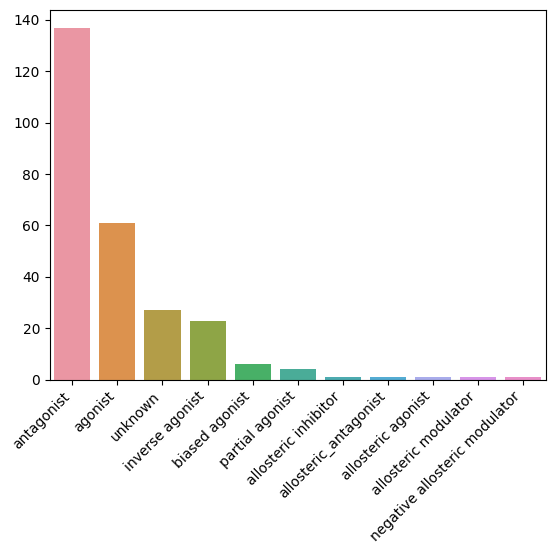

In [52]:
# plot the count of ligand types in dyn_ligtype_dict sorted by cound
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# convert dyn_ligtype_dict to a pandas series
ligand_types = pd.Series(dyn_ligtype_dict.values())
# count the number of each ligand type
ligand_types_count = ligand_types.value_counts()
# plot the count of ligand types
sns.barplot(x=ligand_types_count.index, y=ligand_types_count.values)



# rotate the xticks
plt.xticks(rotation=45, ha="right")
plt.show()

In [70]:
# save dyn_ligtype_dict to a json file
with open("data/processed/dyn_ligtype_dict.json", "w") as f:
    json.dump(dyn_ligtype_dict, f)


## suspicious suff
- 176 paminereg not appears in the article, NMS instead
- 199 morphine not appear in the pdb BU72 instead
- 201 oliceridine not in pdb, BU72 instead

## defective idsm
- 146 (no complex in name)
- 160 (typo in ligand)
- 167 (no complex in name)
- 218 (no ligand in name)
- 841 has inchi key instead of haloperidol
- 927 has inchi instead of carvedilol
- 925 has inchi instead of risperidone
- 931 has inchi instead of vipadenant
- 1100 has the pdb code instead of the receptor



In [55]:
no_sim_list = []
for dynid, (model_name, pdbid) in model_name_dict.items():

    # check if dynid is in the data/raw/lig_type/ folder and has a xtc or dcd file inside
    dcds = glob(f"data/raw/lig_type/{dynid}/*.dcd")
    xtcs = glob(f"data/raw/lig_type/{dynid}/*.xtc")
    if len(dcds) == 0 and len(xtcs) == 0:
        no_sim_list.append(str(dynid))

print(", ".join(no_sim_list))

15, 16, 206, 212, 221, 223, 222, 227, 228, 229, 230, 1089, 1093, 1100, 1105, 1106, 1107, 1109, 1110, 1111, 1108, 1128, 1131, 1137, 1139, 1140, 1141, 1142, 1143, 1144, 1146, 1147, 1150, 1145, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1159, 1160, 1175, 1167, 1176, 1199, 1158, 1215, 1214, 1244, 1245, 1247, 1259, 1246, 1277, 1317, 1284


# Get resname from simulation

In [12]:
from glob import glob
import MDAnalysis as mda
import os

os.chdir("/home/adri/Projects/phd/pipeline")

In [13]:


def identify_ligands(u):
    """
    Identify ligands in a MDAnalysis universe `u` by eliminating common residues 
    for water, ions, and membranes, and then checking for short protein chains.
    """

    # Identify short protein chains as ligands
    possible_ligands = set()
    protein_chains = u.select_atoms("protein").segments
    for seg in protein_chains:
        # log the segment length
        
        if len(seg.residues) < 30:  # Let's assume a threshold of 10 residues for a short protein chain
            possible_ligands.add(f"{seg.segid}")

    # Exclude common water, ions, and membrane residue names.
    common_residues = ['SOL', 'WAT', 'TIP3', 'NA', 'SOD', 'CL', 'CLA',
                        'POP', 'POPC', 'DOPC', 'POPE', 'DOPS', 'PO4', 'CLR',
                        'CHL', 'CHL1', 'POT', 'CYSP', 'DPPC', 'DSPC', 'SDPC',
                         'SM18']

    # Extract all unique non protein residue names from the system
    all_residues = set([res.resname for res in u.select_atoms("not protein").residues if res.segid not in possible_ligands])
    possible_ligands.update(all_residues - set(common_residues))

    return possible_ligands


In [14]:

def load_mda_universe_from_folder(folder_path):
    """
    Load a MDAnalysis universe given a folder. 
    Prioritizes .psf over .pdb for topology and .xtc over .dcd for trajectory.
    """

    # Prioritization orders
    topo_priority = {'.psf': 1, '.pdb': 3, '.top':2}
    traj_priority = {'.xtc': 1, '.dcd': 2}

    # Identify the topology file
    topology_files = [f for f in os.listdir(folder_path) if f.endswith(tuple(topo_priority.keys()))]
    topology_files.sort(key=lambda x: topo_priority[os.path.splitext(x)[1]])
    topology_file = os.path.join(folder_path, topology_files[0]) if topology_files else None

    if not topology_file:
        raise ValueError("No suitable topology file (.psf or .pdb) found in the folder.")

    # Identify the trajectory file
    traj_files = [f for f in os.listdir(folder_path) if f.endswith(tuple(traj_priority.keys()))]
    traj_files.sort(key=lambda x: traj_priority[os.path.splitext(x)[1]])
    trajectory_file = os.path.join(folder_path, traj_files[0]) if traj_files else None

    if not trajectory_file:
        raise ValueError("No suitable trajectory file (.xtc or .dcd) found in the folder.")

    # Load the universe
    u = mda.Universe(topology_file, trajectory_file)
    return u

In [15]:
# iterate trhough the simulation folders
for system_folder in glob("data/raw/simulations/*"):
    # print(system_folder)
    print(system_folder.split('/')[-1], end=": ")
    try:
        u = load_mda_universe_from_folder(system_folder)
    except EOFError:
        # print("EOFError")
        continue
    except ValueError as e:
        # print(e)
        continue

    possible_ligands = identify_ligands(u)

    # if len(possible_ligands) != 1:
    print(f"{system_folder}: {possible_ligands}")
    
    print()

707: data/raw/simulations/707: {'DLB'}

40: data/raw/simulations/40: {'T4G'}

988: data/raw/simulations/988: {'CFF'}

745: data/raw/simulations/745: {'SUV'}

1006: data/raw/simulations/1006: {'AQD'}

729: data/raw/simulations/729: {'P32'}

841: data/raw/simulations/841: {'DNZ'}

1245: 83: data/raw/simulations/83: {'TIM'}

214: 830: data/raw/simulations/830: {'JRZ'}

866: data/raw/simulations/866: {'7MA'}

929: data/raw/simulations/929: {'7OS', 'MK6'}

60: data/raw/simulations/60: {'JDC'}

207: data/raw/simulations/207: {'BUR'}

715: data/raw/simulations/715: {'T4E'}

70: data/raw/simulations/70: {'0NN'}

703: data/raw/simulations/703: {'F9Q'}

976: data/raw/simulations/976: {'9XW'}

733: data/raw/simulations/733: {'DN5'}

804: data/raw/simulations/804: {'ML2'}

790: data/raw/simulations/790: {'KNZ'}

86: data/raw/simulations/86: set()

1076: data/raw/simulations/1076: {'A90'}

875: data/raw/simulations/875: {'NRK'}

971: data/raw/simulations/971: {'CAU'}

1040: data/raw/simulations/104

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


data/raw/simulations/4: {'EJ4'}

990: data/raw/simulations/990: {'QNB'}

7: data/raw/simulations/7: set()

183: data/raw/simulations/183: {'ON7'}

709: data/raw/simulations/709: {'F7N'}

50: data/raw/simulations/50: {'ZMA'}

739: data/raw/simulations/739: {'KNT'}

90: data/raw/simulations/90: {'ERM'}

856: data/raw/simulations/856: {'L76'}

905: data/raw/simulations/905: {'9AF'}

717: data/raw/simulations/717: {'AZJ'}

721: data/raw/simulations/721: {'DLH'}

915: data/raw/simulations/915: {'7MA'}

58: data/raw/simulations/58: {'P32'}

794: data/raw/simulations/794: {'MK6'}

140: data/raw/simulations/140: {'G90'}

185: data/raw/simulations/185: {'ON3'}

820: data/raw/simulations/820: {'ERM'}

176: data/raw/simulations/176: {'3C0'}

188: data/raw/simulations/188: {'4OT'}

42: data/raw/simulations/42: {'T4E'}

994: data/raw/simulations/994: {'JEY'}

194: data/raw/simulations/194: {'0HK'}

887: data/raw/simulations/887: {'K86'}

117: data/raw/simulations/117: {'ALE'}

927: data/raw/simulat

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


data/raw/simulations/9: {'5FW'}

784: data/raw/simulations/784: {'ZMA'}

960: data/raw/simulations/960: {'H8M'}

10: 

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:373: UserWarning: Unknown entry a encountered in formal charge field. This likely indicates that the PDB file is not fully standard compliant. The formalcharges attribute will not be populated.
  warnings.warn(wmsg)


data/raw/simulations/10: {'CAU'}

685: data/raw/simulations/685: {'CAU'}

862: data/raw/simulations/862: {'ZLK'}

814: data/raw/simulations/814: {'T4E'}

796: data/raw/simulations/796: {'JEY'}

903: data/raw/simulations/903: {'NU8'}

1126: 1044: data/raw/simulations/1044: {'A8X'}

713: data/raw/simulations/713: {'JEV'}

946: data/raw/simulations/946: {'JEY'}

901: data/raw/simulations/901: {'LYR'}

687: data/raw/simulations/687: {'UKA'}

219: 123: data/raw/simulations/123: {'JRZ'}

917: data/raw/simulations/917: {'8ES'}

71: data/raw/simulations/71: {'L0'}

881: data/raw/simulations/881: {'L'}

1062: data/raw/simulations/1062: {'L'}

76: data/raw/simulations/76: {'2YB'}

944: data/raw/simulations/944: {'DOK'}

146: data/raw/simulations/146: {'OLM'}

1246: 749: data/raw/simulations/749: {'J9P'}

812: data/raw/simulations/812: {'H8J'}

127: data/raw/simulations/127: {'ML5'}

950: data/raw/simulations/950: {'ZMA'}

160: data/raw/simulations/160: {'CAU'}

806: data/raw/simulations/806: {'K

In [ ]:

# Load the simulation system
u = mda.Universe('path_to_topology_file', 'path_to_trajectory_file')

ligands = identify_ligands(u)
print(ligands)

# search simulations without contacts


In [7]:
from glob import glob
import os
os.chdir("/home/adri/Projects/phd/pipeline")

In [9]:

dcds = glob(f"data/raw/simulations/*/*.dcd")
xtcs = glob(f"data/raw/simulations/*/*.xtc")
trajs = dcds + xtcs

trajs_with_contacts = []
trajs_without_contacts = []

for traj in trajs:
    system = traj.split('/')[-2]
    traj_name = traj.split('/')[-1].split('.')[0]

    contacts_path = f"data/interim/contacts/{system}/{traj_name}_contacts.tsv"

    if os.path.exists(contacts_path):
        trajs_with_contacts.append(traj)
    else:
        trajs_without_contacts.append(traj)

print(f"trajs_with_contacts: {len(trajs_with_contacts)}")
print(f"trajs_without_contacts: {len(trajs_without_contacts)}")


trajs_with_contacts: 388
trajs_without_contacts: 327


# Check which simulations have unfinished contacts

In [15]:
import MDAnalysis as mda

In [24]:
for contacts_path in glob("data/interim/contacts/*/*.tsv"):
    # read the last line of the tsv in a efficient way
    with open(contacts_path, 'rb') as f:
        if os.stat(contacts_path).st_size == 0:
            print(f"{contacts_path}: empty file")
            continue
        f.seek(-2, os.SEEK_END)
        while f.read(1) != b"\n":
            f.seek(-2, os.SEEK_CUR)
        last_line = f.readline().decode()

    # take the first element of the last line
    last_frame = last_line.split('\t')[0]

    # get the number of frames in the trajectory
    system = contacts_path.split('/')[-2]
    replica  = contacts_path.split('/')[-1].replace("_contacts.tsv", "")
    # get the path to the trajectory
    traj_paths = glob(f"data/raw/simulations/{system}/{replica}.*")
    if len(traj_paths) != 1:
        print(f"More than one (or none) trajectory found for {system}/{replica}", traj_paths)
        continue

    traj_path = traj_paths[0]

    # get the number of frames in the trajectory
    path_to_raw = f"data/raw/simulations/{system}"
    topology = (glob(f"{path_to_raw}/*.psf") + glob(f"{path_to_raw}/*.top") +glob(f"{path_to_raw}/*.pdb"))[0]
    u = mda.Universe(topology, traj_path)
    n_frames = u.trajectory.n_frames

    if (int(last_frame)) < (n_frames-2):
        print(f"{contacts_path}: {last_frame} != {n_frames}")


data/interim/contacts/737/15343_trj_737_contacts.tsv: 1899 != 2500


/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:373: UserWarning: Unknown entry a encountered in formal charge field. This likely indicates that the PDB file is not fully standard compliant. The formalcharges attribute will not be populated.
  warnings.warn(wmsg)
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent

data/interim/contacts/830/15980_trj_830_contacts.tsv: 1299 != 2500
data/interim/contacts/994/17083_trj_994_contacts.tsv: 1799 != 2500
data/interim/contacts/994/17082_trj_994_contacts.tsv: 1199 != 2500
data/interim/contacts/691/15024_trj_691_contacts.tsv: 2399 != 2500
data/interim/contacts/33/10367_trj_33_contacts.tsv: 299 != 2500
data/interim/contacts/33/10368_trj_33_contacts.tsv: 2399 != 2500
data/interim/contacts/764/15533_trj_764_contacts.tsv: 1799 != 2500
data/interim/contacts/764/15532_trj_764_contacts.tsv: empty file
data/interim/contacts/69/10681_trj_69_contacts.tsv: 1199 != 2500
data/interim/contacts/38/10415_trj_38_contacts.tsv: empty file
data/interim/contacts/1027/17314_trj_1027_contacts.tsv: 2399 != 2500
data/interim/contacts/1027/17315_trj_1027_contacts.tsv: 1199 != 2500
data/interim/contacts/58/11836_trj_58_contacts.tsv: 1199 != 2500
data/interim/contacts/58/10586_trj_58_contacts.tsv: 1699 != 2500
data/interim/contacts/891/16388_trj_891_contacts.tsv: empty file
data/inter

In [22]:
contacts_path

'data/interim/contacts/764/15532_trj_764_contacts.tsv'

In [20]:
last_frame

'2499'

In [2]:

import argparse
import pandas as pd
from glob import glob
import MDAnalysis as mda
import pickle
import sys
import warnings
from tqdm import tqdm
import os

os.chdir("/home/adri/Projects/phd/pipeline")


sys.path.append('src')
from utils import identify_ligands

In [32]:
folder = "data/interim/frequencies/no_sod_frequencies"

freq_files = glob(f'{folder}/*/*_frequencies.tsv')

freq_df_list = []

# load bw pickled dict
with open('data/interim/formated_bw_dict.pickle', 'rb') as f:
    pdb_to_bw_dict = pickle.load(f)

# load dynid_to_pdb dict
with open('data/interim/dynid_to_pdb.pickle', 'rb') as f:
    dynid_to_pdb = pickle.load(f)

for freq_file in tqdm(freq_files):
    
    system = freq_file.split('/')[-2]
    replica = freq_file.split('/')[-1].split('.')[0].replace('_frequencies', '')
    
    freqs = pd.read_csv(freq_file, 
                    header=None,
                    sep = "\t",
                    skiprows=2,
                    names=["atom1", "atom2", "freq"])
    
    # skip if empty
    if freqs.empty:
        continue

    try:
        freqs[['chain1' , 'resname1', 'resid1']] = freqs.atom1.str.split(':', expand=True)
        freqs[['chain2' , 'resname2', 'resid2']] = freqs.atom2.str.split(':', expand=True)
    except ValueError:
        print(freqs.atom1)

    system_raw_path = f"data/raw/simulations/{system}"

    top_list = (glob(f"{system_raw_path}/*.psf") + glob(f"{system_raw_path}/*.top") + glob(f"{system_raw_path}/*.pdb"))
    assert top_list, f"No topology file found for {system}"
    top = top_list[0]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        ligand = identify_ligands(mda.Universe(top))
    
    ligand = list(ligand)[0]

    if "SEG" in ligand:
        ligand = ligand.replace('SEG:', '')
        # Change ligand id to "LIG"
        freqs.loc[freqs.chain2 == ligand, 'resid2'] = 'LIG'
        freqs.loc[freqs.chain1 == ligand, 'resid1'] = 'LIG'
    else:
        # Change ligand id to "LIG"
        freqs.loc[freqs.resname2 == ligand, 'resid2'] = 'LIG'
        freqs.loc[freqs.resname1 == ligand, 'resid1'] = 'LIG'

    # remove rows where resid1 and resid2 are LIG
    freqs = freqs[~((freqs.resid1 == 'LIG') & (freqs.resid2 == 'LIG'))]

    bw_dict = pdb_to_bw_dict[dynid_to_pdb[int(system)]]
    bw_dict['LIG'] = 'LIG'
        
    contacts = freqs[['resid1', 'resid2']].values

    # Transform the contacts into bw sorted nomenclature
    
    contacts_list = []
    for r1, r2 in contacts:
        r1 = str(r1)
        r2 = str(r2)

        bw_r1 = bw_dict.get(r1, r1)
        bw_r2 = bw_dict.get(r2, r2)

        if bw_r1 is None or bw_r2 is None:
            continue

        sorted_contact = sorted([bw_r1, bw_r2])
        contacts_list.append('-'.join(sorted_contact))

    contacts = contacts_list
    
    freqs = freqs[['freq']].transpose()
    
    freqs.columns = contacts
    
    freqs['replica'] = replica
    
    freqs['system'] = system
    
    freq_df_list.append(freqs.reset_index(drop=True))


  0%|          | 0/395 [00:00<?, ?it/s]

  5%|▌         | 21/395 [00:10<03:05,  2.01it/s]


KeyboardInterrupt: 

In [51]:
pd.Series(freq_df_list[0].columns).value_counts()

4x65-LIG     2
5x43-LIG     2
5x40-LIG     2
5x461-LIG    2
4x61-LIG     2
            ..
2x38-2x41    1
1x53-7x53    1
5x59-5x62    1
3x38-4x50    1
1x35-1x37    1
Name: count, Length: 2774, dtype: int64

In [50]:
pd.concat([freq_df_list[0].reset_index(drop=True), freq_df_list[1].reset_index(drop=True)], ignore_index=True)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [40]:
pd.concat(freq_df_list[0:2], axis=0, ignore_index=True)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [34]:
pd.concat(freq_df_list, ignore_index=True)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:

freq_df = pd.concat(freq_df_list, ignore_index=True)
freq_df = freq_df.fillna(0)
freq_df.to_csv(f'{folder}/merged_frequencies.tsv')

In [3]:
with open('data/interim/dynid_to_pdb.pickle', 'rb') as f:
        dynid_to_pdb = pickle.load(f)

In [5]:
dynid_to_pdb[879]

'4XT3'

In [6]:
with open('data/interim/formated_bw_dict.pickle', 'rb') as f:
        pdb_to_bw_dict = pickle.load(f)

In [8]:
dict_to_inspect = pdb_to_bw_dict['4XT3']

In [11]:
# Get keys mapped to "D19"
keys = [k for k, v in dict_to_inspect.items() if v == 'D19']
print(keys)
keys = [k for k, v in dict_to_inspect.items() if v == 'A20']
print(keys)

['19']
['20']


In [22]:
import MDAnalysis as mda
import os
import pandas as pd
from tqdm import tqdm
os.chdir("/home/adri/Projects/phd/pipeline")

list_of_files = os.listdir("data/raw/simulations")
frames_list = []
for system_folder in tqdm(list_of_files):
    system_name = system_folder.split('/')[-1]
    files = os.listdir(f"data/raw/simulations/{system_folder}")

    # Filtering files based on extensions
    traj_files = [f for f in files if f.endswith(('.xtc', '.dcd'))]
    topologies = [f for f in files if f.endswith(('.psf', '.top', '.pdb'))]

    top = f"data/raw/simulations/{system_folder}/{topologies[0]}"

    for traj in traj_files:
        try:

            traj_path = f"data/raw/simulations/{system_folder}/{traj}"
            # get the length of the simulation
            u = mda.Universe(top, traj_path)
            n_frames = u.trajectory.n_frames
            ns = n_frames * u.trajectory.dt / 1000
            frames_list.append([system_name, n_frames, ns])
        except:
            print(f"Error in {system_folder}/{traj}")



  0%|          | 0/250 [00:00<?, ?it/s]

  2%|▏         | 4/250 [00:04<05:24,  1.32s/it]/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
  4%|▎         | 9/250 [00:08<03:04,  1.31it/s]

Error in 214/11996_trj_214.xtc


  9%|▉         | 23/250 [00:21<04:49,  1.28s/it]/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


Error in 1076/18295_trj_1076.xtc
Error in 1076/18294_trj_1076.xtc
Error in 1076/18296_trj_1076.xtc


 10%|█         | 26/250 [00:23<03:44,  1.00s/it]

Error in 1040/17395_trj_1040.xtc
Error in 1040/17396_trj_1040.xtc
Error in 1040/17397_trj_1040.xtc


 12%|█▏        | 30/250 [00:28<04:07,  1.13s/it]/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:304: UserWarning: Serial numbers went over 100,000.  Higher serials have been guessed
  warnings.warn("Serial numbers went over 100,000.  "
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:423: UserWarning: Invalid atom serials were present, bonds will not be parsed
  warnings.warn("Invalid atom serials were present, bonds will not"
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:215: UserWarning: Invalid atom serials were present, bonds will not be parsed
  warnings.warn("Invalid atom serials were present, "
 14%|█▍        | 36/250 [00:34<04:18,  1.21s/it]

Error in 1124/18582_trj_1124.xtc
Error in 1124/18584_trj_1124.xtc
Error in 1124/18583_trj_1124.xtc


 22%|██▏       | 55/250 [00:52<02:56,  1.10it/s]

Error in 1098/18408_trj_1098.xtc
Error in 1098/18407_trj_1098.xtc
Error in 1098/18409_trj_1098.xtc


 23%|██▎       | 57/250 [00:53<02:40,  1.20it/s]

Error in 1096/18395_trj_1096.xtc
Error in 1096/18393_trj_1096.xtc
Error in 1096/18394_trj_1096.xtc


 27%|██▋       | 67/250 [01:02<02:34,  1.19it/s]

Error in 29/11835_trj_29.xtc


 27%|██▋       | 68/250 [01:03<02:30,  1.21it/s]

Error in 29/11834_trj_29.xtc


 32%|███▏      | 79/250 [01:13<01:54,  1.49it/s]/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
 44%|████▍     | 111/250 [01:50<02:45,  1.19s/it]

Error in 1094/18376_trj_1094.xtc
Error in 1094/18375_trj_1094.xtc
Error in 1094/18374_trj_1094.xtc


 54%|█████▍    | 135/250 [02:16<01:55,  1.01s/it]

Error in 1127/18607_trj_1127.xtc
Error in 1127/18606_trj_1127.xtc
Error in 1127/18608_trj_1127.xtc


 55%|█████▌    | 138/250 [02:19<01:57,  1.05s/it]

Error in 1097/18402_trj_1097.xtc
Error in 1097/18403_trj_1097.xtc
Error in 1097/18401_trj_1097.xtc
Error in 1130/18627_trj_1130.xtc
Error in 1130/18625_trj_1130.xtc
Error in 1130/18626_trj_1130.xtc


 58%|█████▊    | 146/250 [02:25<01:18,  1.32it/s]

Error in 1238/19118_trj_1238.xtc


 59%|█████▉    | 147/250 [02:26<01:35,  1.08it/s]

Error in 1125/18591_trj_1125.xtc
Error in 1125/18592_trj_1125.xtc
Error in 1125/18590_trj_1125.xtc


 64%|██████▍   | 160/250 [02:38<01:42,  1.14s/it]/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:373: UserWarning: Unknown entry 1 encountered in formal charge field. This likely indicates that the PDB file is not fully standard compliant. The formalcharges attribute will not be populated.
  warnings.warn(wmsg)
 78%|███████▊  | 194/250 [03:09<00:51,  1.08it/s]

Error in 1123/18573_trj_1123.xtc
Error in 1123/18575_trj_1123.xtc
Error in 1123/18574_trj_1123.xtc


 83%|████████▎ | 207/250 [03:19<00:32,  1.33it/s]/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:373: UserWarning: Unknown entry a encountered in formal charge field. This likely indicates that the PDB file is not fully standard compliant. The formalcharges attribute will not be populated.
  warnings.warn(wmsg)
 85%|████████▌ | 213/250 [03:25<00:41,  1.12s/it]

Error in 1126/18602_trj_1126.xtc
Error in 1126/18601_trj_1126.xtc
Error in 1126/18600_trj_1126.xtc
Error in 1044/17428_trj_1044.xtc
Error in 1044/17427_trj_1044.xtc
Error in 1044/17426_trj_1044.xtc


 88%|████████▊ | 219/250 [03:30<00:32,  1.05s/it]

Error in 219/12043_trj_219.xtc


 90%|████████▉ | 224/250 [03:35<00:25,  1.04it/s]

Error in 1062/17548_trj_1062.xtc
Error in 1062/17547_trj_1062.xtc
Error in 1062/17546_trj_1062.xtc


100%|██████████| 250/250 [04:01<00:00,  1.03it/s]


In [23]:
frames_df = pd.DataFrame(frames_list, columns=['system', 'n_frames', 'time'])

In [24]:
frames_df

,system,n_frames,time
0,707,2500,500.0
1,707,2500,500.0
2,707,2500,500.0
3,40,2500,500000.0
4,40,2500,500000.0
...,...,...,...
663,1012,2500,500.0
664,1012,2500,500.0
665,1021,2500,500.0
666,1021,2500,500.0


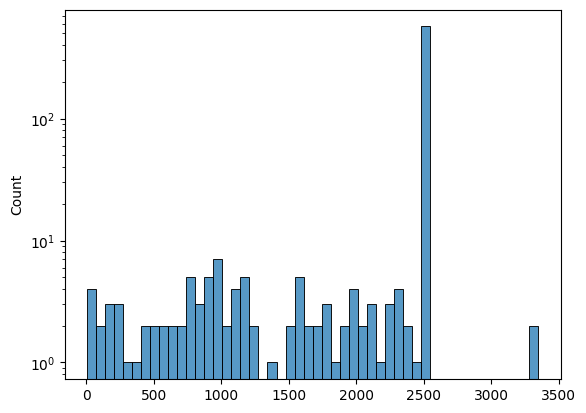

In [25]:
# show distribution of frames per simualtion (less than 4000)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot([f for f in frames_df.n_frames if f < 4000], bins=50)
plt.yscale('log')
plt.show()

In [26]:
frames_df.n_frames.value_counts()

n_frames
2500    568
1000      4
1750      3
3347      2
2000      2
       ... 
5         1
967       1
878       1
500       1
1637      1
Name: count, Length: 90, dtype: int64

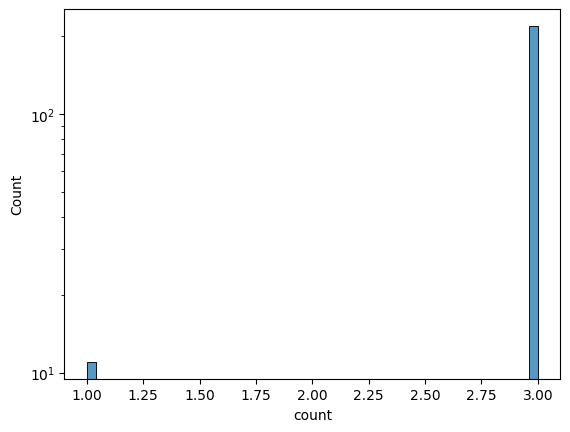

In [27]:
# show distribution of number of replicates per system
sns.histplot(frames_df.system.value_counts(), bins=50)
plt.yscale('log')
plt.show()

<Axes: xlabel='time', ylabel='Count'>

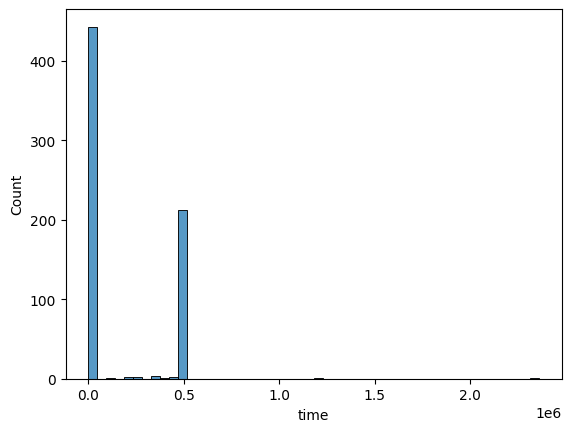

In [29]:
# Check the distribution of duration in nano seconds
sns.histplot(frames_df.time, bins=50)

In [31]:
frames_df.time.value_counts()

time
500.000000       353
500000.000000    212
350000.000000      3
0.000000           3
0.075092           2
                ... 
16.800000          1
9.400000           1
1.000000           1
193.400000         1
30.600000          1
Name: count, Length: 94, dtype: int64

In [32]:
import optuna
import sklearn

In [33]:
print(sklearn.__version__)
optuna.__version__

1.3.0


'3.4.0'

# Feature importance